# 인공지능 정보보안 과제
- kdd99_train.csv 을 이용하여 분류기를 학습시키고,   
kdd99_test.csv 을 이용하여 분류기의 최종 성능을 보고하시오.

## 목차
1. 데이터 로드
2. 데이터 전처리
    1) 분산이 적은 데이터
    2) 상관관계가 큰 데이터
3. 모델학습
4. 모델평가
5. 결론
6. 성능 향상 방법


# 1. 데이터 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time

import warnings
warnings.filterwarnings('ignore')

test_path=os.path.join("data", "kdd99_test.csv")
train_path=os.path.join("data", "kdd99_train.csv")

test_data=pd.read_csv(test_path)
train_data=pd.read_csv(train_path)

### 질문? 중복데이터가 많다고 다 지워야 할까?

- 지워야한다
    - 중복된 데이터로 계속해서 학습 할 시에는 과대 적합이 일어날 확률이 더욱 높아진다
    - 해킹을 인식해야하기 때문에 중복의 데이터는 유의미 하지 않을 수 있다.
- 지우지 말아야한다
    - Ddos 공격같은 경우에는 동일한 데이터가 무차별 적으로 들어온다.(그렇다면 이러한 패턴도 배우게 하면 좋지않을까?)
    - 중복된 양을 모두 지우면 기존의 통계적 특징이 줄어들 가능성이 있다.

##### 결론 : ddos와 같이 지속된 공격의 시계열 특징을 배우게 할 수 있다면 지우지 말고 시계열의 특징을 학습 할 수 없다면 제거하자.

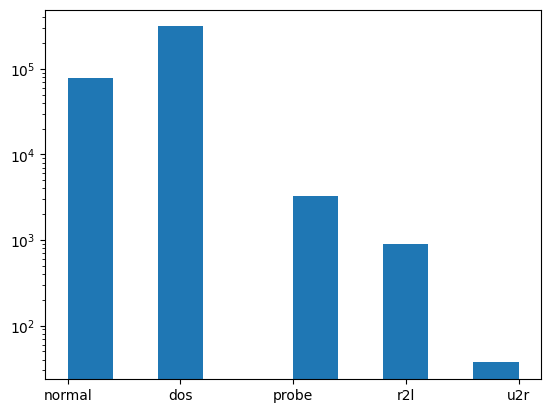

In [2]:
train_data.duplicated().sum() # 275,042의 중복 데이터가 많다.
train_data.dropna(inplace=True)

plt.hist(train_data["Attack Type"])
plt.yscale("log")
plt.show()

# 2. 데이터 전처리  


In [3]:
# train, test 데이터 분리
train_x=train_data.drop(columns=["Attack Type"])
train_y=train_data["Attack Type"]
test_x=test_data.drop(columns=["Attack Type"])
test_y=test_data["Attack Type"]

# y데이터 라벨링
attack_condition=['normal', 'dos', 'probe', 'r2l', 'u2r']
label=[0,1,2,3,4]
train_y=train_y.replace(attack_condition,label)
test_y=test_y.replace(attack_condition,label)


#숫자형 데이터의와 문자형 데이터를 나누어 처리하기 위하여 나누어 놓음.
numerical_cols = train_x._get_numeric_data().columns
categorical_cols = list(set(train_x.columns)-set(numerical_cols))


### Feature의 분산정도에 관해
- 만약에 feature에 동일한 값만 가지는 경우는 어떠한가? 해당 feature에서 유의미한 패턴을 포착할 수 있을까?   
이는 불가하기 때문에 분산이 매우적은 feature는 데이터 전처리 과정에서 빼는 것이 적절하게 특징을 줄일 수 있는 방법일 것이다.

- 질문? 만약 분산이 0이 아닌 0.01 정도의 작은 값을 가지는 경우도 유의미한 데이터 일까? ex)0.0001의 분산을 갖는 lsu_attempted.  
이에 대한 대답은 성능 향상 파트에서 이어가겠다.

In [4]:

 # 2개 이하의 unique값을 가지는 column은 제거
train_x=train_x[[col for col in train_x.columns if train_x[col].nunique()>2]]

numerical_cols = train_x._get_numeric_data().columns

for col in train_x[numerical_cols].columns :
  if train_x[col].var()<1:
    print(f"{col}'s var : {train_x[col].var():.4f}") #0.00



wrong_fragment's var : 0.0187
urgent's var : 0.0000
hot's var : 0.6110
num_failed_logins's var : 0.0003
lsu_attempted's var : 0.0001
lnum_file_creations's var : 0.0104
lnum_access_files's var : 0.0013
serror_rate's var : 0.1450
srv_serror_rate's var : 0.1452
rerror_rate's var : 0.0536
srv_rerror_rate's var : 0.0539
same_srv_rate's var : 0.1507
diff_srv_rate's var : 0.0068
srv_diff_host_rate's var : 0.0203
dst_host_same_srv_rate's var : 0.1688
dst_host_diff_srv_rate's var : 0.0120
dst_host_same_src_port_rate's var : 0.2317
dst_host_srv_diff_host_rate's var : 0.0018
dst_host_serror_rate's var : 0.1449
dst_host_srv_serror_rate's var : 0.1451
dst_host_rerror_rate's var : 0.0531
dst_host_srv_rerror_rate's var : 0.0529


## Pearson Correlation Coefficient
- 피어슨 상관계수(Pearson Correlation Coefficient)는 두 변수 간의 선형적인 관계의 강도와 방향을 수치로 나타내는 통계 지표이다. 값은 -1에서 1 사이이며, 1에 가까울수록 두 변수는 같은 방향으로 강한 양의 선형 관계를, -1에 가까울수록 반대 방향으로 강한 음의 선형 관계를 가진다.
  
- 또한 0에 가까운 값은 선형 관계가 거의 없음을 의미합니다. 즉 상관계수의 절대값이 1에 가까울수록 두 피처에서 얻을 수 있는 패턴은 유사하고 이들 중 하나를 제거하는 것이 학습에 더 유리하다.

- 아래의 코드는 두 변수의 상관계수를 보여주는 히트맵이고 0.85 이상의 절대값을 갖는 상관계수의 피처는 학습에서 제외 했다.

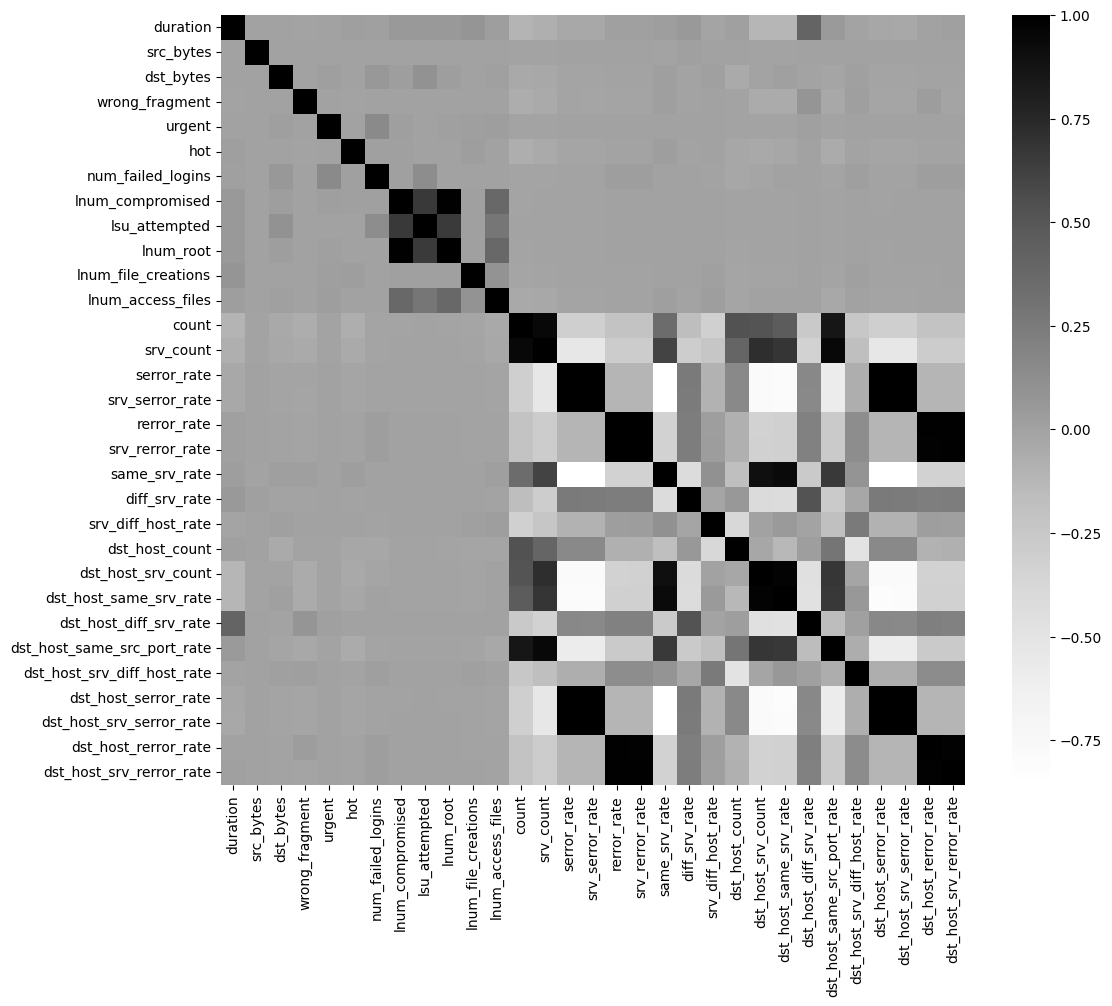

In [5]:
# 상관관계 분석을 위한 히트맵(검은 색 일 수록 상관 관계가 높다)
df=train_x[numerical_cols]
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr,cmap='Greys')
plt.show()

In [6]:
# 2) 상관관계가 높은 피처 제거
dropped_set=set()

for i in range(len(numerical_cols)-1):
    for j in range(i+1, len(numerical_cols)):
        x1 = numerical_cols[i]
        x2 = numerical_cols[j]
        if x1 in dropped_set or x2 in dropped_set:
            continue

        if abs(train_x[x1].corr(train_x[x2]))>0.90:
            # print(f"Correlation between {x1} and {x2}: {train_x[x1].corr(train_x[x2])}")
            dropped_set.add(x2)
# print(dropped_set)

print("num of dropped_cols:", len(dropped_set))

train_x=train_x.drop(columns=dropped_set)

numerical_cols = train_x._get_numeric_data().columns

num of dropped_cols: 9


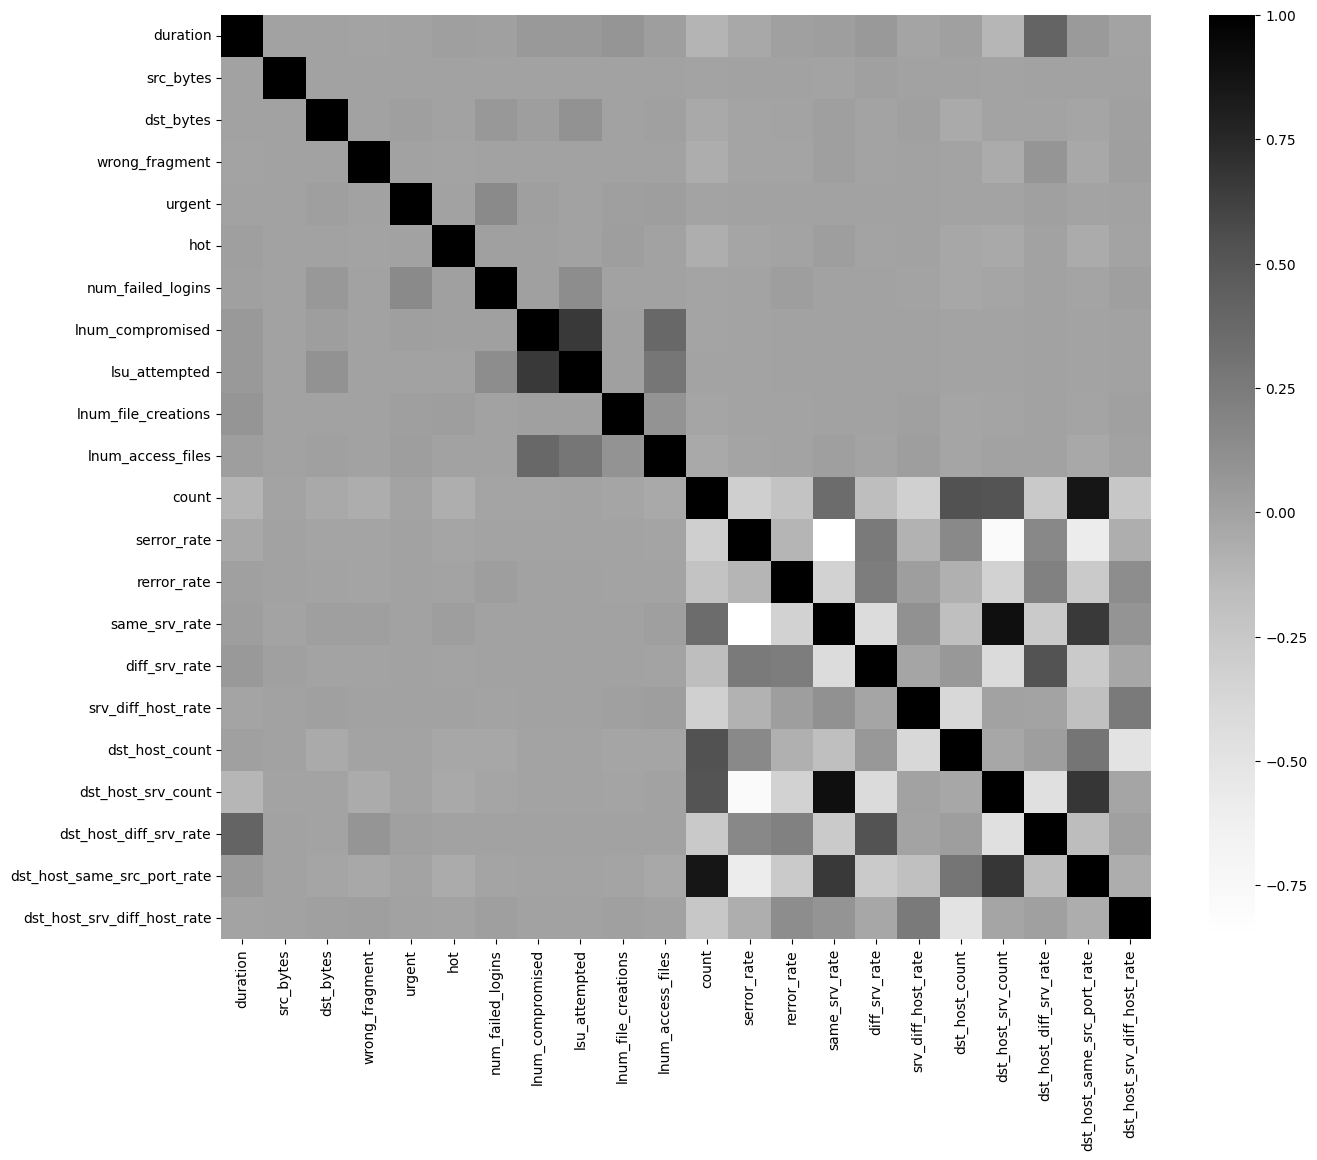

In [7]:
# 재비교 (진한 검은색이 현저히 줄었다)
df=train_x[numerical_cols]
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr,cmap='Greys')
plt.show()

## Categorical data 처리
- 숫자 데이터가 아닌 카테고리컬한 데이터는 기계가 학습하는데 어려움을 갖는데, 이 문제를 해결하기 위해 보통 이런 데이터는 숫자로 바꾸는 라벨 인코딩을 진행한다


In [8]:
# 숫자가 아닌 데이터들의 숫자화
print(train_x[categorical_cols].describe())
categori_mapping_dict = {}
for col in categorical_cols:
    n=0
    df=train_x[col]

    categori_mapping_dict[col]={}
    for item in df.unique():
        categori_mapping_dict[col][item]=n
        n+=1
    train_x[col]=train_x[col].replace(categori_mapping_dict[col])
    test_x[col]=test_x[col].replace(categori_mapping_dict[col])

test_x["service"].replace('tftp_u',-1,inplace=True)


       protocol_type    flag service
count         395216  395216  395216
unique             3      11      65
top             icmp      SF   ecr_i
freq          226735  302750  224993


In [9]:
# train, test 데이터의 피처 개수 맞추기
test_x.drop(columns= list(set(test_x.columns)-set(train_x.columns)), inplace=True)

## 3. 모델학습
- 어떠한 기준으로 모델을 선택하는 것이 좋을까?  
우선 모델의 설명성이 중요한 방어자 입장에서는 설명이 어려운 블랙박스 방식의 신경망 보다는 기계학습 방식이 유리하다. 이를 위해서 아래 4개의 모델을 선택했다.

1. 나이브 베이즈 모델
2. 디시전 트리
3. 랜덤 포레스트
4. XGBoost

In [10]:
from sklearn.metrics import recall_score, f1_score

def get_f1_score(y, pred_y):
    return f1_score(y, pred_y, average='macro')

def get_recall(y, pred_y):
    return recall_score(y, pred_y, average='macro')

In [11]:

from sklearn.naive_bayes import GaussianNB

time_list=[]
acc_list=[]
model_name=[]
f1_list=[]
recall_list=[]

model1 = GaussianNB()
print("GaussianNB")

start_time = time.time()
model1.fit(train_x, train_y)
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred1 = model1.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model1.score(train_x, train_y))
print("Test score is:",model1.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model1.score(test_x,test_y))
model_name.append("GaussianNB")

f1=get_f1_score(test_y, Y_test_pred1)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred1)
print("Recall is:", recall)
recall_list.append(recall)


GaussianNB
Training time:  0.09139418601989746
Testing time:  0.030459165573120117
Train score is: 0.8900221650945306
Test score is: 0.8897919112586535
F1 score is: 0.3440516815961403
Recall is: 0.4602815694422041


In [12]:
from sklearn.tree import DecisionTreeClassifier

model2 = DecisionTreeClassifier(criterion="entropy", max_depth = 10)
print("DecisionTree")

start_time = time.time()
model2.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred2 = model2.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model2.score(train_x, train_y))
print("Test score is:",model2.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model2.score(test_x,test_y))
model_name.append("DecisionTree")

f1=get_f1_score(test_y, Y_test_pred2)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred2)
print("Recall is:", recall)
recall_list.append(recall)


DecisionTree
Training time:  0.30908918380737305
Testing time:  0.006110191345214844
Train score is: 0.9999316829278166
Test score is: 0.9996052791384964
F1 score is: 0.9447979280229936
Recall is: 0.9409158099519885


In [13]:
from sklearn.ensemble import RandomForestClassifier

model3 = RandomForestClassifier(n_estimators=30)
print("RandomForest")

start_time = time.time()
model3.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred3 = model3.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model3.score(train_x, train_y))
print("Test score is:",model3.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model3.score(test_x,test_y))
model_name.append("RandomForest")

f1 = get_f1_score(test_y, Y_test_pred3)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred3)
print("Recall is:", recall)
recall_list.append(recall)




RandomForest
Training time:  2.47674298286438
Testing time:  0.06802892684936523
Train score is: 1.0
Test score is: 0.9996558843771507
F1 score is: 0.9369718576511146
Recall is: 0.9096354665402748


In [14]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
print("XGB")

start_time = time.time()
model.fit(train_x, train_y.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

start_time = time.time()
Y_test_pred4 = model.predict(test_x)
end_time = time.time()
print("Testing time: ",end_time-start_time)

print("Train score is:", model.score(train_x, train_y))
print("Test score is:",model.score(test_x,test_y))

time_list.append(end_time-start_time)
acc_list.append(model.score(test_x,test_y))
model_name.append("XGB")

f1 = get_f1_score(test_y, Y_test_pred4)
print("F1 score is:", f1)
f1_list.append(f1)

recall=get_recall(test_y, Y_test_pred4)
print("Recall is:", recall)
recall_list.append(recall)


XGB
Training time:  2.329332113265991
Testing time:  0.08208990097045898
Train score is: 1.0
Test score is: 0.9998380632363062
F1 score is: 0.9471938133963889
Recall is: 0.9169311050339294


## 5. 결론
- 정보보안 분야에서 모델의 판단기준으로는 정확도, 판단시간, 신뢰성이 있다.
- 아래에 그래프에 따르면 나이브 베이즈 모델을 제외하면 모두 100%에 근접한 정확도를 가졌다.
- 모델의 신뢰성을 판단하기 위해서는 f1 score가 유용하다.
- 또한, 한번이라도 공격을 허용하면 위험한 정보보안 분야에서 양성인 것을 양성으로 판단하는 Recall이 이에 효과적이다.
### 결과적으로 판단시간 대비 recall의 값이 가장 뛰어난 디시전트리가 해당과제에서 가장 효율적인 모델로 선택되었다.


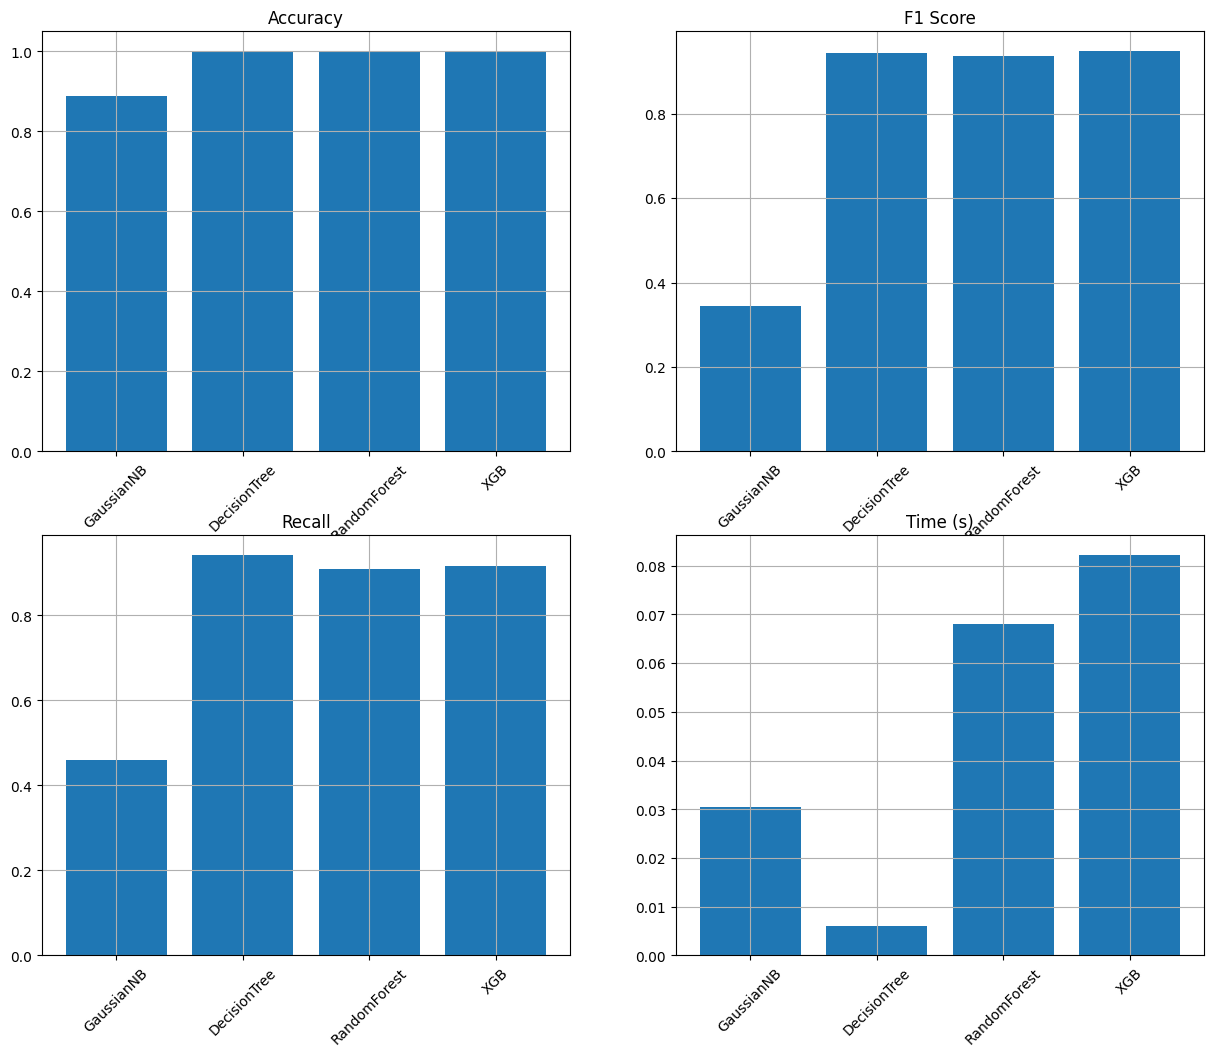

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

axs[0, 0].bar(model_name, acc_list)
axs[0, 0].set_title('Accuracy')

axs[0, 1].bar(model_name, f1_list)
axs[0, 1].set_title('F1 Score')

axs[1, 0].bar(model_name, recall_list)
axs[1, 0].set_title('Recall')

axs[1, 1].bar(model_name, time_list)
axs[1, 1].set_title('Time (s)')

for ax in axs.flat:
    ax.grid(True)
    ax.set_xticklabels(model_name, rotation=45)

plt.show()

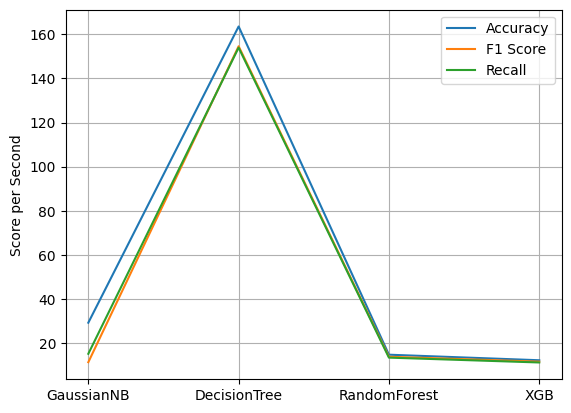

In [16]:
acc_list=np.array(acc_list)
time_list=np.array(time_list)
f1_list=np.array(f1_list)
recall_list=np.array(recall_list)

plt.plot(model_name, acc_list/time_list, label='Accuracy')
plt.plot(model_name, f1_list/time_list, label='F1 Score')
plt.plot(model_name, recall_list/time_list, label='Recall')
plt.ylabel('Score per Second')

plt.legend()
plt.grid(True)
plt.show()

## 6. 성능 향상 방법
- 위에서 서술 했던 듯이 분산 값이 매우 작은 피처는 유의미한 설명성을 가질까?
- 이를 위해 decision Tree에서 각각의 피처의 중요도를 확인해보았다.

In [17]:
importances = model2.feature_importances_
# 피처 이름과 함께 데이터프레임으로 변환
feature_importance_df = pd.DataFrame({
    'feature': train_x.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

def show_var_and_importances(threshold=1):
  for col in train_x[numerical_cols]:
    importance=feature_importance_df[feature_importance_df['feature']==col]['importance'].values[0]
    var=train_x[col].var()
    if var<threshold:
      print(col)
      print(f"var :{var:.4f} importance {importance*100:.4f}%")
      print()
show_var_and_importances()

wrong_fragment
var :0.0187 importance 0.3351%

urgent
var :0.0000 importance 0.0000%

hot
var :0.6110 importance 3.2820%

num_failed_logins
var :0.0003 importance 0.0000%

lsu_attempted
var :0.0001 importance 0.0000%

lnum_file_creations
var :0.0104 importance 0.0029%

lnum_access_files
var :0.0013 importance 0.0000%

serror_rate
var :0.1450 importance 0.1592%

rerror_rate
var :0.0536 importance 0.0006%

same_srv_rate
var :0.1507 importance 0.0032%

diff_srv_rate
var :0.0068 importance 3.5055%

srv_diff_host_rate
var :0.0203 importance 0.0082%

dst_host_diff_srv_rate
var :0.0120 importance 0.1351%

dst_host_same_src_port_rate
var :0.2317 importance 0.3013%

dst_host_srv_diff_host_rate
var :0.0018 importance 0.0826%



결과에 따르면 var이 1보다 작다고 중요도가 낮은 것은 아니다. 하지만 일정 수치 이하(약 0.005)에서는 중요도가 0에 가까워진다.  
따라서 해당 피처들을 제외하고 정확도가 낮았던 나이브 베이즈 모델로 학습을 진행해본다.

In [18]:
show_var_and_importances(0.005)

urgent
var :0.0000 importance 0.0000%

num_failed_logins
var :0.0003 importance 0.0000%

lsu_attempted
var :0.0001 importance 0.0000%

lnum_access_files
var :0.0013 importance 0.0000%

dst_host_srv_diff_host_rate
var :0.0018 importance 0.0826%



In [19]:
delete_col=["urgent","num_failed_logins","lsu_attempted","lnum_access_files","dst_host_srv_diff_host_rate"]
train_x.drop(columns=delete_col, inplace=True)
test_x.drop(columns=delete_col, inplace=True)

improved_model = GaussianNB()
improved_model.fit(train_x,train_y)


print("Train score is:", improved_model.score(train_x, train_y))
print("Test score is:",improved_model.score(test_x,test_y))
pred=improved_model.predict(test_x)
f1=get_f1_score(test_y, pred)
print("F1 score is:", f1)

recall=get_recall(test_y, pred)
print("Recall is:", recall)



Train score is: 0.8900221650945306
Test score is: 0.8897919112586535
F1 score is: 0.3440516815961403
Recall is: 0.4602815694422041


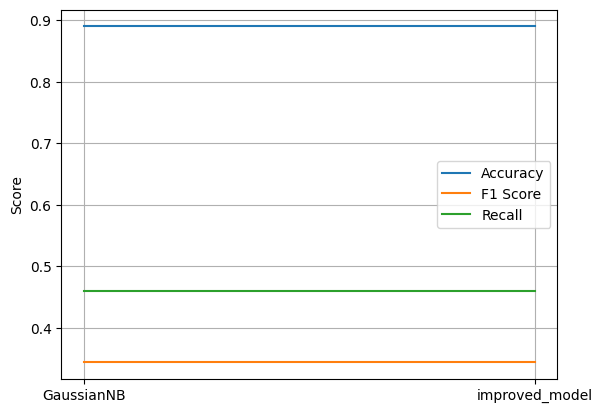

In [20]:
x=[model_name[0],"improved_model"]
y=[acc_list[0],improved_model.score(test_x,test_y)]
z=[f1_list[0],f1]
w=[recall_list[0],recall]

plt.plot(x, y, label='Accuracy')
plt.plot(x, z, label='F1 Score')
plt.plot(x, w, label='Recall')
plt.ylabel('Score')

plt.legend()
plt.grid(True)
plt.show()

- 피처를 4개를 없앴지만 성능에 변화가 없었다.
- 어느 정도 작은 분산의 피처는 제외해도 되는 것을 확인했다.

In [21]:
dropped_set=[]
for col in train_x._get_numeric_data().columns :
  if train_x[col].var()<1:
    print(f"{col}'s var : {train_x[col].var():.4f}") #0.00
    dropped_set.append(col)
train_x.drop(columns=dropped_set, inplace=True)
test_x.drop(columns=dropped_set, inplace=True)

light_model=GaussianNB()
light_model.fit(train_x,train_y)

print("Train score is:", light_model.score(train_x, train_y))
print("Test score is:",light_model.score(test_x,test_y))

f1=get_f1_score(test_y, light_model.predict(test_x))
print("F1 score is:", f1)

recall=get_recall(test_y, light_model.predict(test_x))
print("Recall is:", recall)




protocol_type's var : 0.3081
flag's var : 0.3672
wrong_fragment's var : 0.0187
hot's var : 0.6110
lnum_file_creations's var : 0.0104
serror_rate's var : 0.1450
rerror_rate's var : 0.0536
same_srv_rate's var : 0.1507
diff_srv_rate's var : 0.0068
srv_diff_host_rate's var : 0.0203
dst_host_diff_srv_rate's var : 0.0120
dst_host_same_src_port_rate's var : 0.2317
Train score is: 0.8900297558803287
Test score is: 0.8897817902109226
F1 score is: 0.3440064401931712
Recall is: 0.4602712420643253


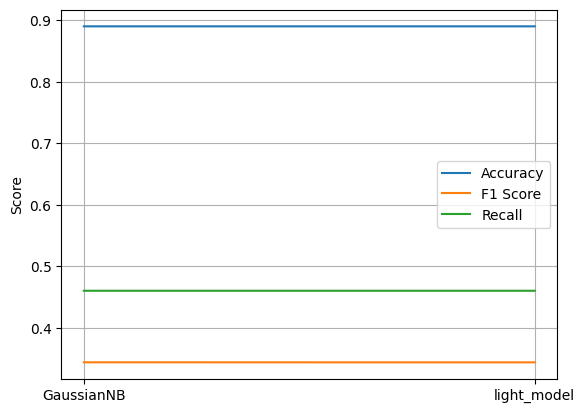

In [22]:
x=[model_name[0],"light_model"]
y=[acc_list[0],light_model.score(test_x,test_y)]
z=[f1_list[0],f1]
w=[recall_list[0],recall]

plt.plot(x, y, label='Accuracy')
plt.plot(x, z, label='F1 Score')
plt.plot(x, w, label='Recall')
plt.ylabel('Score')

plt.legend()
plt.grid(True)
plt.show()

## 질문에 대한 답 : 작은 분산의 데이터는 모델 학습에 큰 도움을 주지 못함으로 해당 특징을 없애는 것이 이롭다.

# 최종 결론
- 데이터 전처리 과정에서 특징을 선택 할때 상관계수가 1에 가까운 데이터를 없애는 것 뿐 아니라, 어느 정도 수준으로 작은 분산을 가진 데이터는 모델에서 크게 도움을 주지 않으므로 해당 피처는 없애는 것이 좋다
- 또한 정보보안 분야에서 모델을 판단하는데 중요한 정확도, 신뢰도, 판단 시간의 지표를 총합했을 때 다른 모델들과 정확도및 f1 score와 재현율(recall)은 비슷하지만 판단시간이 짧은 Decision tree가 가장 좋은 분류기이다.